In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
data = pd.read_csv("NYSE.CSV")
data = data.drop(["Open","High","Low","Adjustment Factor","Adjustment Type"],1)
print(data.shape)
print(data.head())
col = "Close"
great = datetime(2017,1,5,0,0)

(2862, 3)
         Date  Close     Volume
0  2017-12-15  93.17  1228616.0
1  2017-12-14  89.31   609024.0
2  2017-12-13  88.48   296605.0
3  2017-12-12  87.82   356485.0
4  2017-12-11  86.77   367014.0


2862


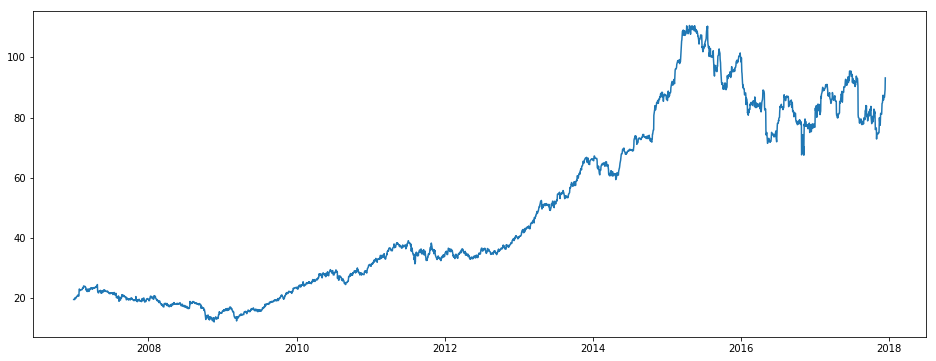

In [17]:
from datetime import datetime, date, time
def timestamp(time):
    year = int(time[0:4])
    month = int(time[5:7])
    day = int(time[8:10])
    hr = 0
    mn = 0
    timestamp = datetime(year,month,day,hr,mn)
    return timestamp
data["Date"] = data["Date"].apply(lambda x: timestamp(str(x)))
#data = data[(data["Date"] > great)]
X = np.array(data["Date"])
Y = np.array(data[col])
print(X.size)
plt.figure(figsize=(16,6))
plt.plot(X,Y)
#plt.title("Original data plot")
plt.show()

--- 0.001999378204345703 seconds ---
572


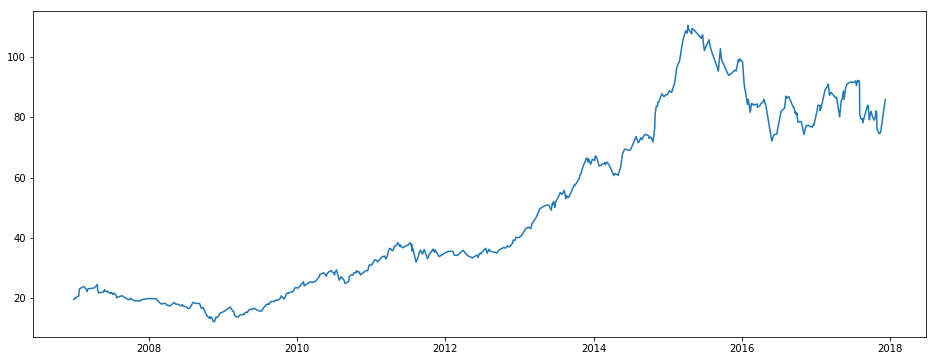

In [9]:
#Random Sampling
import time
start = time.time()
df = data.sample(frac=0.2, replace=True)
#print(data.head())
df = df.sort_values(["Date"])
end = time.time()
print("--- %s seconds ---" % (end - start))
print(len(df))
x = np.array(df["Date"])
y = np.array(df[col])
#print(df.head())
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("Random sampling")
plt.show()

3323.3950334164147
<class 'pandas.core.frame.DataFrame'>
(572, 3)
--- 0.003978729248046875 seconds ---
572


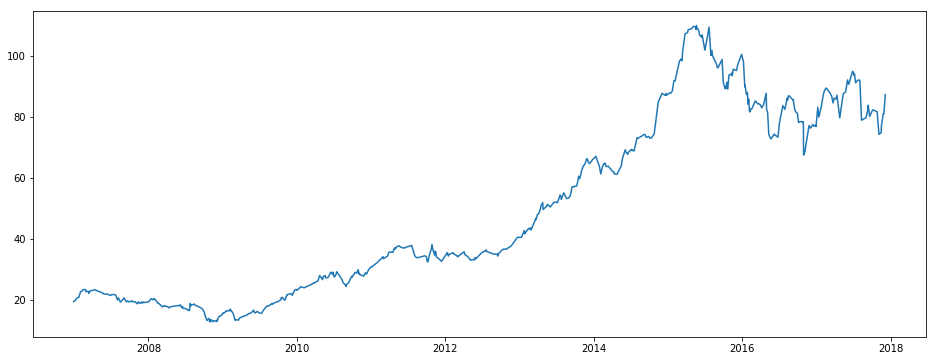

In [10]:
#Stratified Sampling

import calendar


def toTimestamp(d):
  return calendar.timegm(d.timetuple())
def get_error(original, sample):
    error = 0.0
    samd = sample.copy()
    samd['Date'] = samd['Date'].apply(lambda x: toTimestamp(x))
    X = np.array(samd["Date"])
    Y = np.array(samd[col])
    for index, row in original.iterrows():
        time = toTimestamp(row["Date"])
        val = np.interp(time,X,Y)
        error += (row[col] - val)**2
    return error
start_err = get_error(data,df)
print(start_err)

from sklearn.model_selection import StratifiedShuffleSplit
start = time.time()
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - 0.2, random_state=0)

T = [0]*data.shape[0]
traini= sss.split(data,T)
D = pd.DataFrame()
for t,i in traini:
    print(type(data.iloc[t]))
    D = data.iloc[t]
#print(D)
print(D.shape)
D = D.sort_values(["Date"])
end = time.time()
print("--- %s seconds ---" % (end - start))
print(len(D))
x = np.array(D["Date"])
y = np.array(D[col])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("Stratified sampling")
plt.show()

In [11]:
#Window Sampling (PASS)

def window_sample(data,theta = 5):
    if(len(data) <=2):
        return data
    ret = []
    first = data.iloc[0]
    second = data.iloc[1]
    x1 = toTimestamp(first["Date"])
    x2 = toTimestamp(second["Date"])
    y1 = first[col]
    y2 = second[col]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = toTimestamp(prev["Date"])
        x2 = toTimestamp(current["Date"])
        y1 = prev[col]
        y2 = current[col]
        current_angle = np.rad2deg(np.arctan2(1.0*abs(y2-y1), 1.0*abs(x2-x1)/3600))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            ret.append(current)
        prev = current
    ret.append(prev)
    return ret
start = time.time()
sample = window_sample(data,1.9)
end = time.time()
print("--- %s seconds ---" % (end - start))

seen = {}
final = []
for a in sample:
    if  a["Date"] not in seen:
        final.append(a)
        seen[a["Date"]] = True
len(final)

--- 0.2700002193450928 seconds ---


541

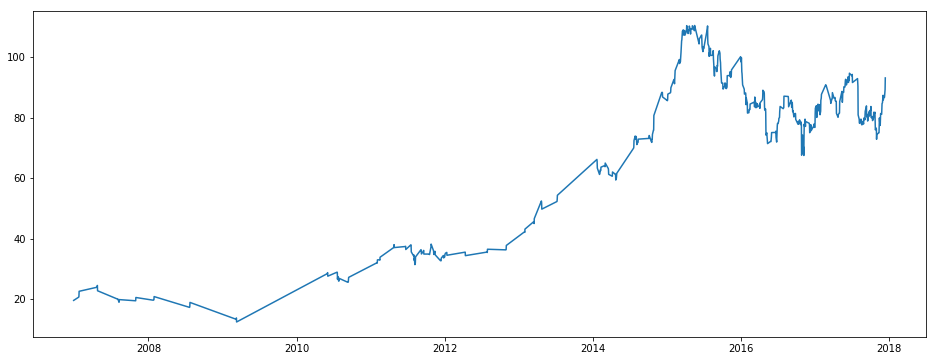

In [12]:
dframe = pd.DataFrame(sample)
x = np.array(dframe["Date"])
y = np.array(dframe[col])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("WinSample")
plt.show()
#dframe.head()

In [4]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PAA
%matplotlib inline
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    _range = int(_range)
    print(_range, "range")
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) // resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    for w in range(2, len(data) // max_window + 1):
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    _range = int(_range)
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

<class 'list'>
--- 0.16802167892456055 seconds ---
477


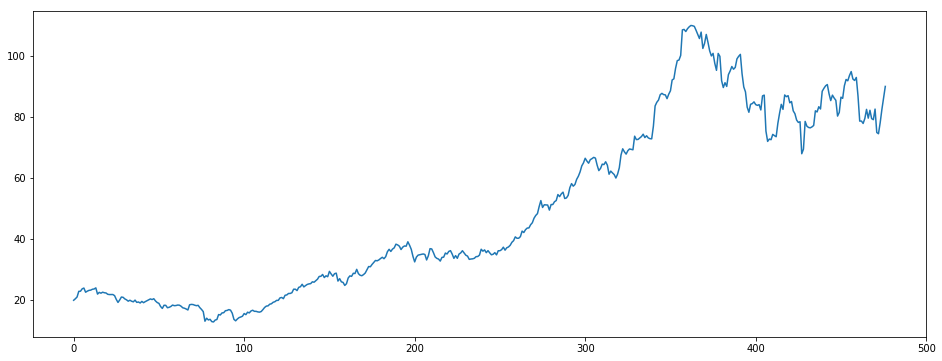

In [7]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    print("Data size", len(data))
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()
    return data
# Read data from CSV
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data
# Temp ASAP
import sys
import numpy as np
nyse_data = load_csv('NYSE.csv')
start = time.time()
win_size, s_size = smooth_ASAP(nyse_data, resolution=1000)
#window_size, slide_size = smooth_simple(raw_data, resolution=1000)
data = SMA(nyse_data, s_size, s_size)
smoothed = SMA(data, win_size, 3)
smoothed = smoothed[::-1]
print(type(smoothed))
smoothed_range = range(int(win_size/2), int(win_size/2) + len(smoothed))
end = time.time()
print("--- %s seconds ---" % (end - start))
print(len(smoothed))


#plot(temp_data, win_size, s_size)

plt.figure(figsize=(16,6))
plt.plot(smoothed_range,smoothed)


#plt.axis('off')
#plt.title("ASAP")
#plt.savefig('window_taxi.pdf')
plt.show()

573
0.004998207092285156


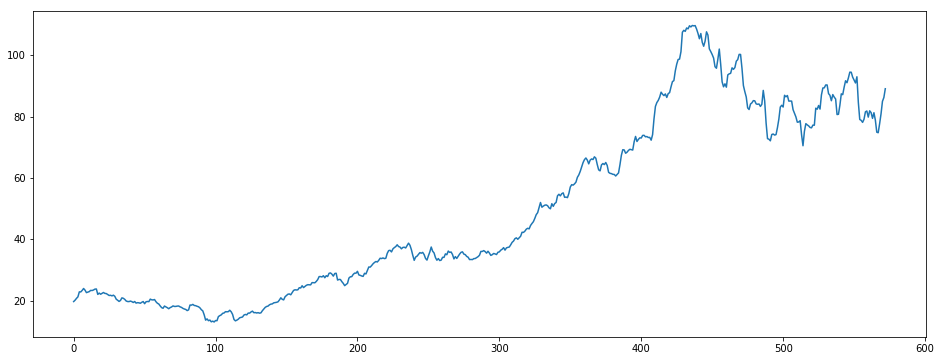

In [30]:
#PAA
import time
start=time.time()
window_size = 5
paa = PAA(window_size=window_size)
X_paa = paa.transform([data[col]])
print(len(X_paa[0]))
plt.figure(figsize=(16,6))
#plt.title("PAA(Window Size=5)")
X_paa[0] = X_paa[0][::-1]
end=time.time()
print(end-start)
plt.plot(X_paa[0])
plt.show()

477


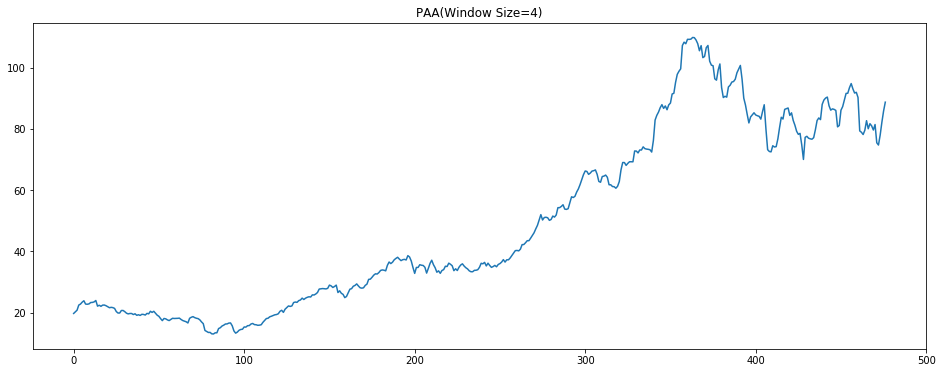

In [27]:
#PAA
window_size = 6
paa = PAA(window_size=window_size)
X_paa = paa.transform([data[col]])
print(len(X_paa[0]))
plt.figure(figsize=(16,6))
plt.title("PAA(Window Size=4)")
X_paa[0] = X_paa[0][::-1]
plt.plot(X_paa[0])
plt.show()

In [13]:
#M4
import time
start=time.time()
w = 150
print(4 * w)
#nyse_data.shape
#print(nyse_data.head())
def m4(data, w):
    wsize = data.shape[0]//w
    ret = []
    seen = {}
    for g in range(0,w):
        maxv = None
        minv = None
        first = None
        last = None
        indices = [0,0,0,0]
        for i in range(g*wsize, g*wsize + wsize):
            if minv is None:
                minv = data.iloc[i]
                indices[0] = i
            elif data.iloc[i][col] < minv["Close"]:
                minv = data.iloc[i]
                indices[0] = i
            if maxv is None:
                maxv = data.iloc[i]
                indices[1] = i
            elif data.iloc[i].Close > maxv.Close:
                maxv = data.iloc[i]
                indices[1] = i
            if i == g*wsize:
                first = data.iloc[i]
                indices[2] = i
            if i == g*wsize + wsize - 1:
                last = data.iloc[i]
                indices[3] = i
        indices.sort()
        for j in range(0, len(indices)):
            if indices[j] in seen:
                continue
            seen[j] = True
            ret.append(data.iloc[indices[j]])
    df = pd.DataFrame(ret)
    #df = df.sort_values("timestamp")
    return df
ret = m4(data,w)
end=time.time()
print(end-start)
#ret["Close"] = ret["Close"][::-1]

600
0.9961347579956055


599


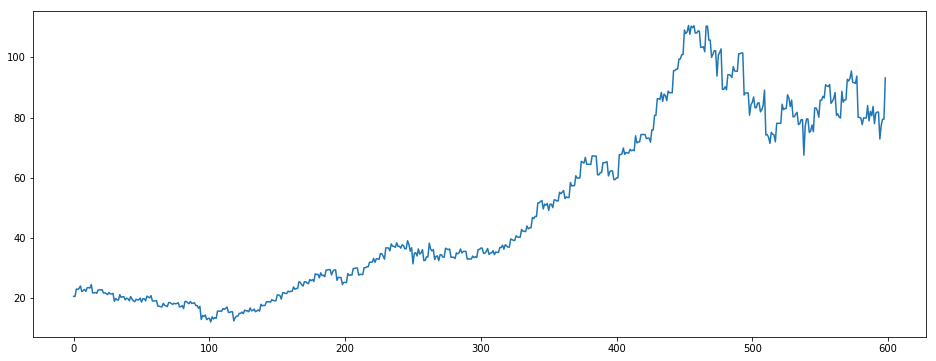

In [14]:
#M4
x = np.array(ret["Close"])
x = x[::-1]
plt.figure(figsize=(16,6))
plt.plot(x)
print(len(ret["Close"]))
fig = plt.gcf()
#plt.title("M4")
#plt.savefig('M4_taxi.pdf')
plt.show()

0.819990873336792
600


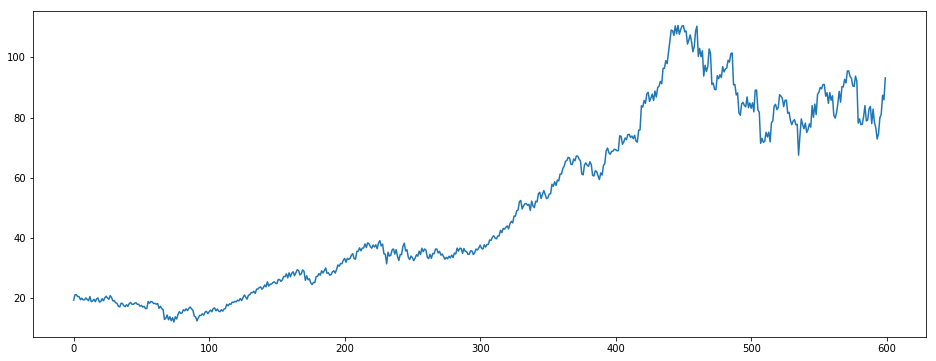

In [15]:
#MinMax
start=time.time()
def minmax(data, w):
    wsize = data.shape[0]//w
    ret = []
    seen = {}
    for g in range(0,w):
        maxv = None
        minv = None
        indices = [0,0]
        for i in range(g*wsize, g*wsize + wsize):
            if minv is None:
                minv = data.iloc[i]
                indices[0] = i
            elif data.iloc[i]["Close"] < minv["Close"]:
                minv = data.iloc[i]
                indices[0] = i
            if maxv is None:
                maxv = data.iloc[i]
                indices[1] = i
            elif data.iloc[i].Close > maxv.Close:
                maxv = data.iloc[i]
                indices[1] = i
        indices.sort()
        for j in range(0, len(indices)):
            if indices[j] in seen:
                continue
            seen[j] = True
            ret.append(data.iloc[indices[j]])
    df = pd.DataFrame(ret)
    #df = df.sort_values("timestamp")
    return df

ret = minmax(data,2*w)
end=time.time()
print(end-start)
#Minmax

plt.figure(figsize=(16,6))
x = np.array(ret["Close"])
x = x[::-1]


plt.plot(x)
print(len(ret["Close"]))
fig = plt.gcf()
#plt.title("Minmax")
#plt.savefig('M4_taxi.pdf')
plt.show()

In [33]:
#RDP
import calendar
data["Date"] = data["Date"]
data["Close"] = data["Close"].apply(lambda x : float(x))
data.head()
#print(taxi_data.head())
def toTimestamp(d):
  return calendar.timegm(d.timetuple())
def toTimestamp(d):
  return calendar.timegm(d.timetuple())
# from datetime import datetime, date, time
# data = pd.read_csv("NYSE.CSV")
# data = data.drop(["Open","High","Low","Adjustment Factor","Adjustment Type"],1)
print(data.head())
# x = np.array(data["Date"].apply(lambda x : toTimestamp(x)))
# y = np.array(data["Close"].apply(lambda x : float(x)))
D = []
for i in range(0,len(x)):
    D.append([x[i],y[i]])
from rdp import rdp
start = time.time()
dp = rdp(D, epsilon = 1)
end = time.time()
print("--- %s seconds ---" % (end - start))
dframe = pd.DataFrame(dp)
print(len(dp))
x = np.array(data["Date"].apply(lambda x : toTimestamp(x)))
y = np.array(data["Close"].apply(lambda x : float(x)))
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("RDP sampling")
plt.show()

         Date  Close     Volume
0  2017-12-15  93.17  1228616.0
1  2017-12-14  89.31   609024.0
2  2017-12-13  88.48   296605.0
3  2017-12-12  87.82   356485.0
4  2017-12-11  86.77   367014.0


TypeError: ufunc subtract cannot use operands with types dtype('O') and dtype('<m8[ns]')

--- 0.06899523735046387 seconds ---
544


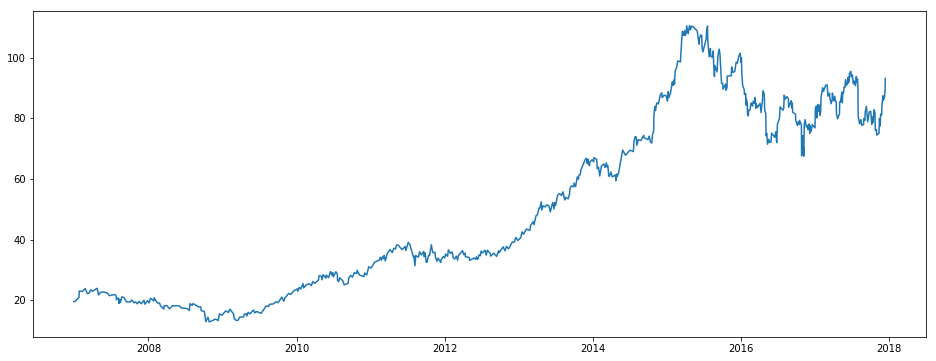

In [28]:
#VW
import time
import visvalingamwyatt as vw
start = time.time()
D = []
for i in range(0,len(X)):
    D.append([X[i],Y[i]])
simplifier = vw.Simplifier(D)
vwd = simplifier.simplify(ratio = .19)
end = time.time()
print("--- %s seconds ---" % (end - start))

print(len(vwd))
dframe = pd.DataFrame(vwd)
x = np.array(dframe[0])
y = np.array(dframe[1])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("VWD sampling")
plt.show()